# Notebook Description:

This analysis notebook leverages student audios that are graded by humans and [Azure's Pronunciation Assessment](https://learn.microsoft.com/en-us/azure/ai-services/speech-service/how-to-pronunciation-assessment?pivots=programming-language-csharp) service to:
- compare human and Automatic Speech Recognition Services (ASR) scores
- compute word-level metrics (WER, Levenshtein distance, fluency comparisons)
- extract word-level tables and summaries
- compute per-student WCPM (words correct per minute)
- generate confusion matrices and heatmaps

## Installing Requirements
Please install the relevant packages if you haven't done so already.

In [1]:
# ! pip3 install -r ../requirements.txt

## Importing Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from helper_functions import calculate_transcription_metrics, compare_word_fluency, compare_sentence_fluency, calculate_ai_fluency, _parse_dict, normalize_word
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display


## Loading Data
Loading in data that's an output of `scripts/2. merging.py` – this script combines the human graded dataset with ASR responses, consolidates variable names, and standardizes feedback scores (in a dictionary-like format). 

Notes:

The human graded dataset only includes data from: 
- Grade 1
- 3 Questions
- 2 Graders (Ali & Salman)

The dictionary format is as follows:
- `feedback_human_json`: _'{"it's": 2, "locked": 1, "i": 2, "can": 1, "open": 2, "it": 2}'`_. Here, the key corresponds to a word, and the value corresponds to the human assigned score.
- `feedback_ai_json`: _'{"it's": {"actual_score": 94.0, "normalized_score": 1.88, "normalized_rounded": 2}, "locked": {"actual_score": 61.0, "normalized_score": 1.22, "normalized_rounded": 1}}_

In [3]:
file_path = "../data/clean/merged_for_analysis.csv"
df_merged = pd.read_csv(file_path).drop_duplicates()
df_merged.columns

Index(['student_profile_id', 'question_text', 'question_number',
       'difficulty_level', 'pre_or_post', 'transcription_human',
       'transcription_ai', 'score_human_total', 'score_human_max',
       'feedback_human_json', 'feedback_ai_json',
       'ai_utterance_duration_seconds', 'grader_name', 'grader_notes',
       'ai_submission_id', 'lesson_id', 'question_id', 'submission_date',
       'audio_filename', 'audio_link', 'ai_utterance_duration_seconds.1',
       'city', 'schoolName', 'question_text_original', 'grade'],
      dtype='object')

## Calculating Normalized Fluency scores.
We calculate total scores based on both human and AI grading, and calculate the average normalized score for both cases.

Currently human and AI scores are based on a 0-2 metric, we normalize these to create the following:
- Human fluency (`human_fluency_normalized`) on a 0-1 scale.
- AI fluency:
  - continuous score (0-2 e.g: 0.4, 1.1, 1.5) -> normalized to 0-1
  - discrete/rounded variant (0, 1, 2) -> normalized to 0-1

In [4]:
# Calculate normalized fluency scores from existing columns
print("\nCalculating normalized fluency scores...")

# Human fluency: score_human_total / score_human_max (normalized to 0-1)
df_merged['human_fluency_normalized'] = df_merged.apply(
    lambda row: row['score_human_total'] / row['score_human_max'] 
    if pd.notna(row.get('score_human_max')) and row.get('score_human_max', 0) > 0 
    else 0.0, 
    axis=1
)

# Calculate both continuous and discrete AI fluency scores
df_merged['ai_fluency_normalized'] = df_merged.apply(lambda row: calculate_ai_fluency(row, use_rounded=False), axis=1)
df_merged['ai_fluency_normalized_rounded'] = df_merged.apply(lambda row: calculate_ai_fluency(row, use_rounded=True), axis=1)

# Clamp to [0, 1]
df_merged['human_fluency_normalized'] = df_merged['human_fluency_normalized'].clip(0, 1)
df_merged['ai_fluency_normalized'] = df_merged['ai_fluency_normalized'].clip(0, 1)
df_merged['ai_fluency_normalized_rounded'] = df_merged['ai_fluency_normalized_rounded'].clip(0, 1)


print(f"Human fluency range: [{df_merged['human_fluency_normalized'].min():.3f}, {df_merged['human_fluency_normalized'].max():.3f}]")
print(f"AI fluency (continuous) range: [{df_merged['ai_fluency_normalized'].min():.3f}, {df_merged['ai_fluency_normalized'].max():.3f}]")
print(f"AI fluency (rounded) range: [{df_merged['ai_fluency_normalized_rounded'].min():.3f}, {df_merged['ai_fluency_normalized_rounded'].max():.3f}]")

print("\nFluency scores (out of 1):")
print(f"Average Human Fluency: {df_merged['human_fluency_normalized'].mean():.3f}")
print(f"Average AI Fluency (continuous): {df_merged['ai_fluency_normalized'].mean():.3f}")
print(f"Average AI Fluency (rounded): {df_merged['ai_fluency_normalized_rounded'].mean():.3f}")


Calculating normalized fluency scores...
Human fluency range: [0.000, 1.000]
AI fluency (continuous) range: [0.000, 0.987]
AI fluency (rounded) range: [0.000, 1.000]

Fluency scores (out of 1):
Average Human Fluency: 0.883
Average AI Fluency (continuous): 0.770
Average AI Fluency (rounded): 0.817


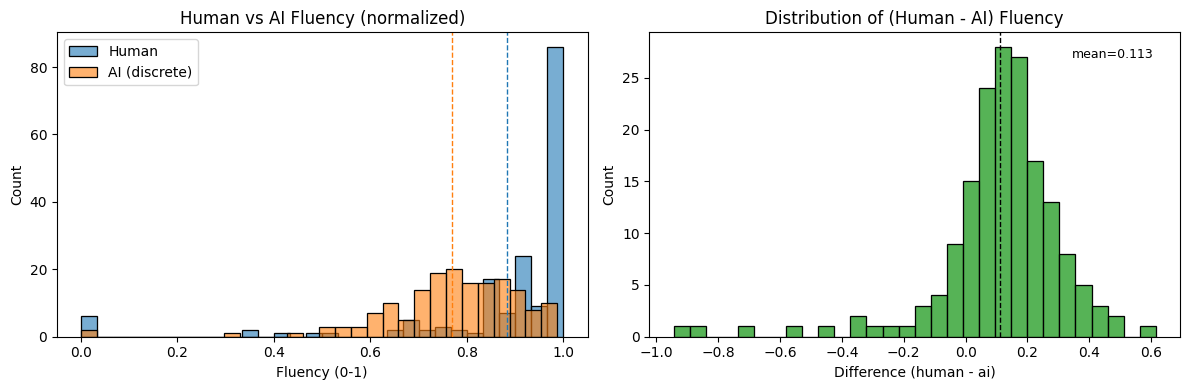

In [5]:

plt.rcParams.update({'figure.autolayout': True})
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overlayed hist: human vs AI (continuous)
sns.histplot(df_merged['human_fluency_normalized'].dropna(), bins=30, color='C0', alpha=0.6, label='Human', ax=axes[0])
sns.histplot(df_merged['ai_fluency_normalized'].dropna(), bins=30, color='C1', alpha=0.6, label='AI (discrete)', ax=axes[0])
axes[0].axvline(df_merged['human_fluency_normalized'].mean(), color='C0', linestyle='--', linewidth=1)
axes[0].axvline(df_merged['ai_fluency_normalized'].mean(), color='C1', linestyle='--', linewidth=1)
axes[0].set_title('Human vs AI Fluency (normalized)')
axes[0].set_xlabel('Fluency (0-1)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Histogram of differences (human - AI)
diff = (df_merged['human_fluency_normalized'] - df_merged['ai_fluency_normalized']).dropna()
sns.histplot(diff, bins=30, color='C2', alpha=0.8, ax=axes[1])
axes[1].axvline(diff.mean(), color='k', linestyle='--', linewidth=1)
axes[1].set_title('Distribution of (Human - AI) Fluency')
axes[1].set_xlabel('Difference (human - ai)')
axes[1].set_ylabel('Count')
axes[1].annotate(f"mean={diff.mean():.3f}", xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=9)

plt.show()

### Findings:

1. Human graders are more lenient: Humans average 88.3% fluency scores

2. AI is systematically stricter:
- Continuous AI scoring is ~11 percentage points lower than humans
- Even rounded/discrete AI scoring is still ~7 percentage points lower
- This suggests AI has more conservative thresholds for pronunciation quality


## Additional Metrics
Here, we leverage Python's [`jiwer`](https://pypi.org/project/jiwer/) library to calculate:
- **Word Error Rate (WER)**: measures transcription accuracy by calculating the percentage of incorrect words (substituions, insertions, deletions) compared to human reference, with lower scores indicating better performance.
- **Levenshtein**: mean edit-distance (number of insert/delete/substitute operations).

In [6]:
# %%
metrics_df = df_merged.apply(calculate_transcription_metrics, axis=1, result_type='expand')
df_merged = pd.concat([df_merged, metrics_df], axis=1)

# %%
print("=== Transcription Accuracy Summary ===")
print(f"Average WER (Human <> Reference Text): {df_merged['wer_human'].mean()}")
print(f"Average WER (AI <> Reference Text): {df_merged['wer_ai'].mean()}")
print(f"Average WER (AI <> Human Text): {df_merged['wer_human_ai'].mean()}")

print(f"\nLevenshtein – Human <> Text: {df_merged['levenshtein_human'].mean()}")
print(f"Levenshtein – AI <> Text: {df_merged['levenshtein_ai'].mean()}")
print(f"Levenshtein – Human <> AI: {df_merged['levenshtein_human_ai'].mean()}")


=== Transcription Accuracy Summary ===
Average WER (Human <> Reference Text): 0.3805860805860805
Average WER (AI <> Reference Text): 0.4028458720766413
Average WER (AI <> Human Text): 0.3763525839709272

Levenshtein – Human <> Text: 7.136094674556213
Levenshtein – AI <> Text: 8.680473372781066
Levenshtein – Human <> AI: 5.047337278106509


### Findings:

**Word Error Rate**:
- Human vs Reference Text: 38.1% WER - human graders detect errors in 38% of the words.
- AI vs Reference Text: 40.3% WER - AI detects slightly more errors compared to humans (~40.3%)
- AI vs Human Text: 37.6% WER - AI and human transcriptions differ in ~37.6% of words

**Levenshtein Distance**:
- Human <> Reference: 7.14 edits — on average human transcriptions need ~7 edits to match the reference text (reflects student deviations).
- AI <> Reference: 8.68 edits — AI transcripts need ~1.54 more edits than humans vs the reference (AI slightly worse vs reference).

## Correlations

In order to compare pronunciation assessment to human judges, we leverage pearson correlations ([as recommended by Azure](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/speech-service/pronunciation-assessment/characteristics-and-limitations-pronunciation-assessment?view=foundry-classic#:~:text=Comparing%20Pronunciation%20Assessment%20to%20Human%20Judges)). This is what Azure recommends. 

- `pearson_correlation`: Pearson r between human and AI per-word scores (NaN if undefined).
- `spearman_correlation`: Spearman rho (rank agreement).
- `mae_word_level`: mean absolute error between human and AI word scores.
- `num_words_compared`: number of matched word pairs used for each row.

Notes:

- Correlations near 1 = strong agreement; near 0 = little/no linear (or rank) agreement.
- MAE: average per-word score difference (lower is better).



In [7]:
# %%
# Apply word-level analysis
print("\nCalculating word-level fluency metrics...")
fluency_metrics = df_merged.apply(compare_word_fluency, axis=1, result_type='expand')
df_merged = pd.concat([df_merged, fluency_metrics], axis=1)
print("\n=== Word-Level Fluency Comparison ===")
print(f"Average Pearson Correlation: {df_merged['pearson_correlation'].mean()}")

print(f"Average Spearman Correlation: {df_merged['spearman_correlation'].mean()}")
print(f"Average MAE (Word Level): {df_merged['mae_word_level'].mean()}")
print(f"Average Words Compared per Audio: {df_merged['num_words_compared'].mean()}")


Calculating word-level fluency metrics...

=== Word-Level Fluency Comparison ===
Average Pearson Correlation: 0.4370421865929341
Average Spearman Correlation: 0.4306807869888043
Average MAE (Word Level): 0.33994347506617445
Average Words Compared per Audio: 7.384615384615385


/Users/rukhshanarifmian/beaj-audio-dataset/scripts/helper_functions.py:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(human_word_scores, ai_word_scores)
/Users/rukhshanarifmian/beaj-audio-dataset/scripts/helper_functions.py:192: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(human_word_scores, ai_word_scores)


### Findings:
- A Pearson Correlation of 0.43 indicates a [medium](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/speech-service/pronunciation-assessment/characteristics-and-limitations-pronunciation-assessment?view=foundry-classic#:~:text=perception%20of%20humans.-,Medium,-0.3%20to%200.5) strength of association. This means that the autogenerated scores from Azure are aligned with the perception of humans, but differences still exist, and people might not agree with the result. 
- Spearman correlation indicates a similar moderate agreement — AI and humans mostly rank words similarly.
- AI is reasonably aligned with human graders but not interchangeable.


## T-Tests:

- Purpose: test whether the *mean* sentence-level fluency scores differ between human and AI on the *same* items.



In [8]:
paired = df_merged[["human_fluency_normalized", "ai_fluency_normalized_rounded"]].dropna()

if len(paired) >= 2:
    h = paired['human_fluency_normalized'].to_numpy()
    a = paired['ai_fluency_normalized_rounded'].to_numpy()
    diff = h - a

    # Paired t-test
    t_res = ttest_rel(h, a, nan_policy='omit')

    # Wilcoxon signed-rank test (non-parametric alternative)
    w_res = None
    try:
        # wilcoxon requires non-zero differences for some versions; wrap in try
        w_res = wilcoxon(diff)
    except Exception:
        w_res = None

    # Effect size (Cohen's d for paired samples)
    mean_diff = float(np.nanmean(diff))
    std_diff = float(np.nanstd(diff, ddof=1)) if len(diff) > 1 else np.nan
    cohen_d = mean_diff / std_diff if std_diff and std_diff > 0 else np.nan

    # Bootstrap 95% CI for mean difference
    rng = np.random.default_rng(0)
    n_boot = 2000
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(diff), len(diff))
        boots.append(np.mean(diff[idx]))
    lo_ci, hi_ci = np.percentile(boots, [2.5, 97.5])

    print("\n=== Paired Fluency Tests (Human - AI) ===")
    print(f"N paired = {len(diff)}")
    print(f"Paired t-test: t = {t_res.statistic}, p = {t_res.pvalue}")
    if w_res is not None:
        print(f"Wilcoxon signed-rank p = {w_res.pvalue}")
    print(f"Mean difference (human - AI) = {mean_diff}")
    print(f"Bootstrap 95% CI for mean diff = ({lo_ci}, {hi_ci})")
    print(f"Cohen's d (paired) = {cohen_d}")
else:
    print("Not enough paired samples to run t-test / Wilcoxon. Need at least 2 paired observations.")


=== Paired Fluency Tests (Human - AI) ===
N paired = 169
Paired t-test: t = 3.895348359104325, p = 0.0001413334932617841
Wilcoxon signed-rank p = 1.4315397614340854e-08
Mean difference (human - AI) = 0.06600226696380543
Bootstrap 95% CI for mean diff = (0.03108749957307651, 0.09756193859559242)
Cohen's d (paired) = 0.29964218146956345


### Findings: 
Humans are systematically more lenient than the Azure's pronunciation assessment service by ~3–9 percentage points (Confidence Interval) on average. Cohen's d indicates a small-moderate  effect size, while the small p-values allows us to reject the null hypothesis (Human = AI).

Note: 
Cohen's d tells us how big a difference between two groups is by counting it in "standard deviation" units.
- If d = 1 → the groups' means differ by 1 standard deviation (big).
- If d = 0.5 → means differ by half a standard deviation (medium).
- If d = 0.2 → small difference.

## Word Level Comparisons

Here, we compare human and ASR grading at the word level.

In [9]:

rows = []

for _, r in df_merged.iterrows():
    h = _parse_dict(r.get('feedback_human_json'))
    a = _parse_dict(r.get('feedback_ai_json'))

    if not h or not a:
        continue

    # Create normalized lookup for AI scores to handle punctuation differences
    ai_normalized_lookup = {}
    for word, ai_obj in a.items():
        normalized_word = normalize_word(word)
        if normalized_word:  # Skip empty strings
            ai_normalized_lookup[normalized_word] = ai_obj
    
    # Match using normalized words
    for w, hscore in h.items():
        normalized_w = normalize_word(w)
        if not normalized_w:  # Skip empty strings
            continue
            
        if normalized_w not in ai_normalized_lookup:
            continue

        ai_obj = ai_normalized_lookup[normalized_w]
        if not isinstance(ai_obj, dict):
            continue

        ai_score = ai_obj.get('normalized_rounded')  # discrete 0/1/2
        if ai_score is None:
            continue

        try:
            hval = float(hscore)
            aval = float(ai_score)
        except:
            continue

        rows.append({
            "word": normalized_w,  # Store normalized word for consistency
            "human_score": hval,
            "ai_score": aval,
            "diff_h_minus_ai": hval - aval,
            "abs_diff": abs(hval - aval),
            "mismatch": int(hval != aval),
        })

word_df = pd.DataFrame(rows)

# aggregate per word
word_summary = (
    word_df.groupby("word")
    .agg(
        n=("word", "size"),
        mean_human=("human_score", "mean"),
        mean_ai=("ai_score", "mean"),
        mean_diff=("diff_h_minus_ai", "mean"),
        mae=("abs_diff", "mean"),
        mismatch_rate=("mismatch", "mean"),
    )
    .reset_index()
    .sort_values(["n", "mae"], ascending=[False, False])
)

# optional: filter to words that appear often enough so it's meaningful
word_summary_filtered = word_summary[word_summary["n"] >= 10].copy()

out_path = "../data/clean/word_level_summary.csv"
word_summary_filtered.to_csv(out_path, index=False)

print("Saved:", out_path)
print("\nTop words by MAE (n>=10):")
print(word_summary_filtered.sort_values("mae", ascending=False).head(20))

Saved: ../data/clean/word_level_summary.csv

Top words by MAE (n>=10):
        word    n  mean_human   mean_ai  mean_diff       mae  mismatch_rate
5       faiz   48    1.750000  1.000000   0.750000  1.000000       0.833333
19  together   47    1.765957  1.042553   0.723404  0.765957       0.638298
0      build   49    1.857143  1.224490   0.632653  0.673469       0.428571
2       come   47    1.978723  1.340426   0.638298  0.638298       0.446809
11    locked   53    1.377358  1.169811   0.207547  0.584906       0.584906
20        we   51    1.921569  1.529412   0.392157  0.509804       0.450980
16    things   49    1.836735  1.387755   0.448980  0.489796       0.387755
13        on   51    1.921569  1.568627   0.352941  0.470588       0.450980
21      zara   56    1.928571  1.500000   0.428571  0.464286       0.446429
4       draw   54    1.851852  1.629630   0.222222  0.370370       0.333333
10      it's   53    1.849057  1.622642   0.226415  0.339623       0.264151
12     loves   57

### Findings:
- Faiz (n=48): large disagreement indicates AI under-scores this word more frequently. This is a name, and relatively South Asian specific.
- _Together / build / come_ also show large positive mean_diff (humans higher);
- "loves" is one example where AI scores higher on average (mean_diff negative).
- Common function words (can, we, is, to, this, he, do) have smaller mean differences and a lower mismatch rate.

Overall pattern: some specific words (especially South Asian specific names or perhaps ASR-errors) produce large, consistent disagreements whereas others have higher agreement + lower mismatch rates.

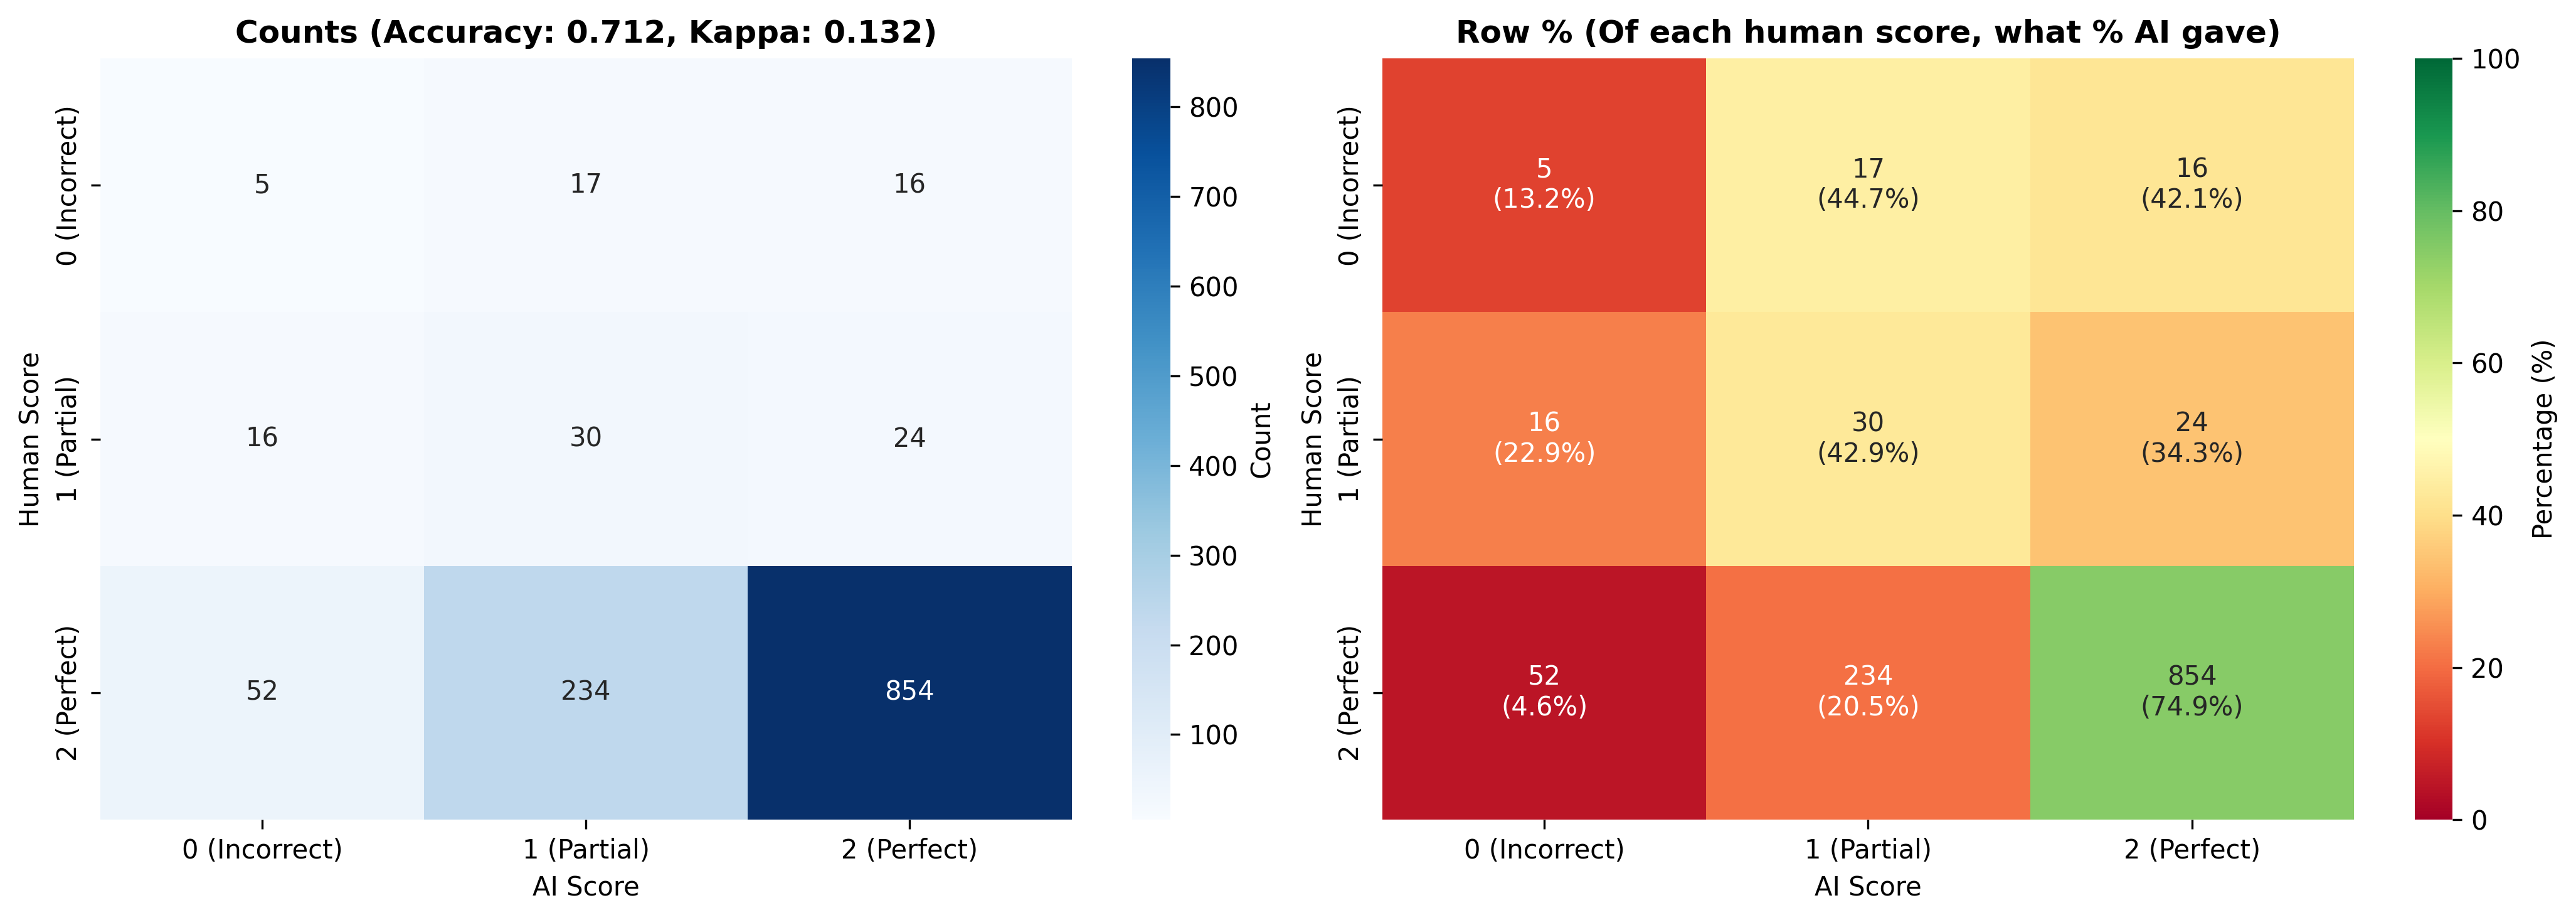

In [10]:
# need to add the code to create this
display(Image(filename="../plots/overall_confusion_matrix.png"))

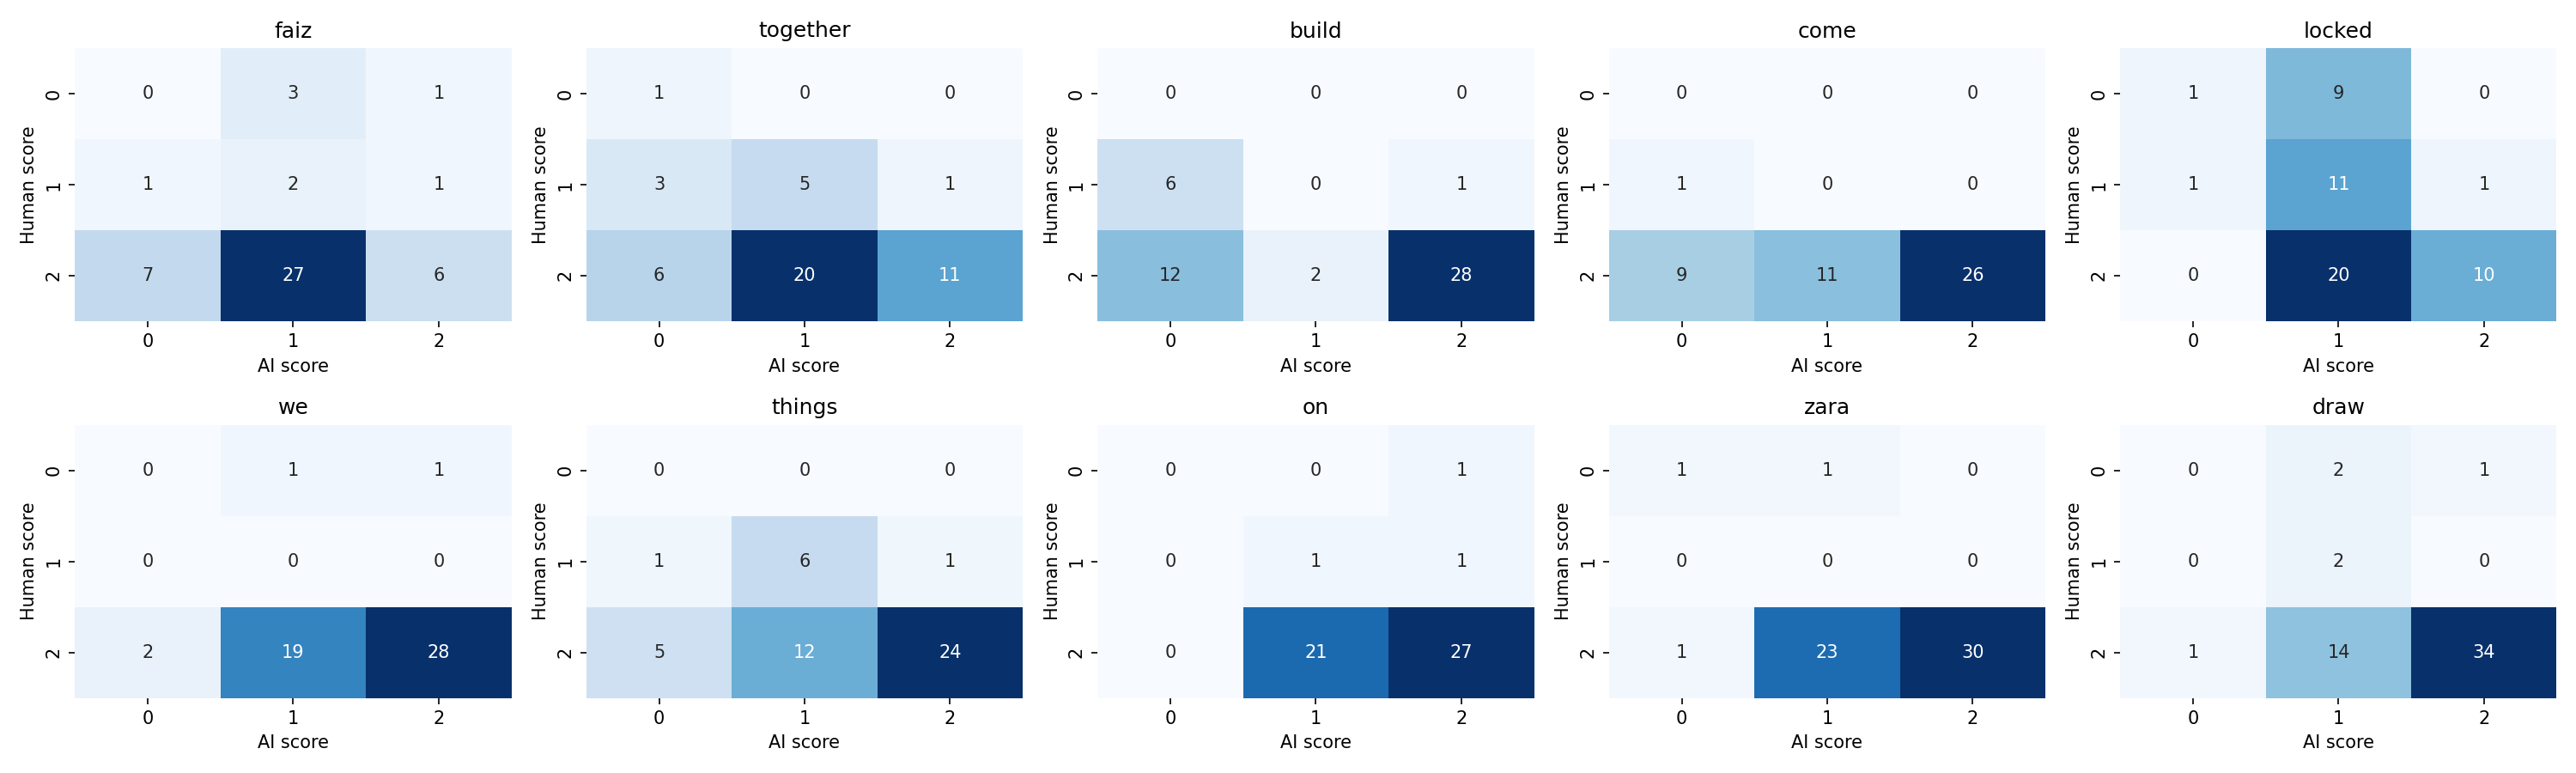

In [11]:
# need to add the code to create this
display(Image(filename="../plots/top10_word_confusion_heatmaps.png"))

## Calculating Words Correct Per Minute

The following chunk of code computes and compares per-student "Words Correct Per Minute" (WCPM) for human and ASR graders. 

We consider two definitions of a "correct" word:
- "Perfect" word pronunciation and decoding (score = 2 out of 2)
- "Partial" word pronunciation and decoding (score >= 1 out of 2)

Duration is calculated using the following method:
- We extract the spoken-audio duration (in seconds) from the ASR feedback structure that lists words with timing.
- Compute per word timing (start and end) by leveraging the offset and duration variables provided to us in the JSON response from Azure.
    - Offset = when a word starts in the audio (relative to the utterance).
    - Duration = how long that word’s audio lasts.

In [12]:
# %%
# Calculate words correct per minute (WCPM) by student
from helper_functions import calculate_words_correct_per_minute

print("="*80)
print("WORDS CORRECT PER MINUTE (WCPM) ANALYSIS")
print("="*80)

wcpm_df = calculate_words_correct_per_minute(df_merged, group_by_col='student_profile_id')

# Sort by human WCPM (partial) descending
wcpm_df = wcpm_df.sort_values('human_wcpm_partial', ascending=False)

print(f"\nAnalyzed {len(wcpm_df)} students")
print(f"Total submissions: {wcpm_df['num_submissions'].sum()}")
print(f"\nOverall Statistics:")
print(f"  Human WCPM (partial, score>=1): {wcpm_df['human_wcpm_partial'].mean():.2f} ± {wcpm_df['human_wcpm_partial'].std():.2f}")
print(f"  Human WCPM (perfect, score=2):  {wcpm_df['human_wcpm_perfect'].mean():.2f} ± {wcpm_df['human_wcpm_perfect'].std():.2f}")
print(f"  AI WCPM (partial, score>=1):    {wcpm_df['ai_wcpm_partial'].mean():.2f} ± {wcpm_df['ai_wcpm_partial'].std():.2f}")
print(f"  AI WCPM (perfect, score=2):     {wcpm_df['ai_wcpm_perfect'].mean():.2f} ± {wcpm_df['ai_wcpm_perfect'].std():.2f}")

print("\n" + "="*80)
print("TOP 20 STUDENTS BY HUMAN WCPM (PARTIAL)")
print("="*80)
display_cols = ['student_profile_id', 'human_wcpm_partial', 'human_wcpm_perfect', 
                'ai_wcpm_partial', 'ai_wcpm_perfect', 'num_submissions', 
                'total_duration_minutes']
print(wcpm_df[display_cols].head(20).to_string(index=False))

print("\n" + "="*80)
print("HUMAN vs AI WCPM COMPARISON")
print("="*80)
# Calculate differences
wcpm_df['wcpm_diff_partial'] = wcpm_df['human_wcpm_partial'] - wcpm_df['ai_wcpm_partial']
wcpm_df['wcpm_diff_perfect'] = wcpm_df['human_wcpm_perfect'] - wcpm_df['ai_wcpm_perfect']

print(f"\nMean difference (Human - AI):")
print(f"  Partial (score>=1): {wcpm_df['wcpm_diff_partial'].mean():.2f} words/min")
print(f"  Perfect (score=2):  {wcpm_df['wcpm_diff_perfect'].mean():.2f} words/min")

print(f"\nCorrelation (Human vs AI WCPM):")
from scipy.stats import pearsonr, spearmanr
if len(wcpm_df) > 2:
    r_partial, p_partial = pearsonr(wcpm_df['human_wcpm_partial'], wcpm_df['ai_wcpm_partial'])
    r_perfect, p_perfect = pearsonr(wcpm_df['human_wcpm_perfect'], wcpm_df['ai_wcpm_perfect'])
    print(f"  Partial: r={r_partial:.3f}, p={p_partial:.4f}")
    print(f"  Perfect: r={r_perfect:.3f}, p={p_perfect:.4f}")

WORDS CORRECT PER MINUTE (WCPM) ANALYSIS

Analyzed 89 students
Total submissions: 169

Overall Statistics:
  Human WCPM (partial, score>=1): 89.75 ± 43.27
  Human WCPM (perfect, score=2):  85.34 ± 43.67
  AI WCPM (partial, score>=1):    80.42 ± 40.56
  AI WCPM (perfect, score=2):     63.01 ± 42.24

TOP 20 STUDENTS BY HUMAN WCPM (PARTIAL)
 student_profile_id  human_wcpm_partial  human_wcpm_perfect  ai_wcpm_partial  ai_wcpm_perfect  num_submissions  total_duration_minutes
              28399          277.777778          277.777778       236.111111       222.222222                3                0.072000
              28512          240.000000          240.000000       240.000000       240.000000                1                0.029167
              28388          181.451613          169.354839       133.064516       133.064516                1                0.082667
              28390          171.428571          171.428571       171.428571       171.428571                1          

## Findings:

Humans rate students faster on average than the AI. AI is moderately more conservative when requiring “perfect” words; the gap is smaller when partial credit is allowed. BUT (very important):

- Standard deviations are large (~40–44 WCPM), so there is wide between‑student variability.
- These means can be very sensitive to very short `total_duration_minutes` – WCPM blows up if durations are small, which they are in this case (0.07 minutes for the student with the highest WCPM). 

We need more data for the same students to better estimate WCPM.


## Saving Sample Datasets

In [13]:
df_final = df_merged.copy().drop(columns=['difficulty_level'])
df_final.to_csv("../data/clean/final_analysis_dataset.csv", index=False)
print(f"\n→ Saved final analysis dataset to: ../data/clean/final_analysis_dataset.csv")


→ Saved final analysis dataset to: ../data/clean/final_analysis_dataset.csv


In [14]:
wcpm_output_path = "../data/clean/wcpm_by_student.csv"
wcpm_df.to_csv(wcpm_output_path, index=False)
print(f"\n→ Saved WCPM data to: {wcpm_output_path}")


→ Saved WCPM data to: ../data/clean/wcpm_by_student.csv
